# Text classification with Preprocessed Text: Movie reviews
## Tensorflow Tutorial
In this tutorial I will use TensorFlow and Keras to perform binary classification. I will classify movie reviews as positive or negative using the text of the review.

### Data
I'll use the IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Database. These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are balanced, meaning they contain an equal number of positive and negative reviews.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
tf.enable_eager_execution()

print(tf.__version__)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

1.14.0


### Downloading the Data
The IMDB movie reviews dataset comes packaged in `tfds`. It has already been preprocessed so that the reviews (sequences of words) have been converted to sequences of integers, where each integer represents a specific word in a dictionary.

In [2]:
(train_data, test_data), info = tfds.load(
    # using the version pre-encoded with an ~8k vocabulary.
    'imdb_reviews/subwords8k', 
    # Return the train/test datasets as a tuple.
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    # Return (example, label) pairs from the dataset (instead of a dictionary).
    as_supervised=True,
    # Also return the `info` structure. 
    with_info=True)

### The encoder
The dataset info includes the text encoder (`tfds.features.text.SubwordTextEncoder`).

In [3]:
encoder = info.features['text'].encoder
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


The text encoder will reversibly encode any string:

In [4]:
sample_string = 'TensorFlow is great'
#encoding
encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

#decoding
original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

assert original_string == sample_string

Encoded string is [6307, 2327, 4043, 4265, 9, 526]
The original string: "TensorFlow is great"


The encoder encodes the string by breaking it into subwords or characters if the word is not in its dictionary. So the more a string resembles the dataset, the shorter the encoded representation will be

In [5]:
for ts in encoded_string:
    print('{} ----> {}'.format(ts, encoder.decode([ts])))

6307 ----> Ten
2327 ----> sor
4043 ----> Fl
4265 ----> ow 
9 ----> is 
526 ----> great


## Exploring the data
It is important to understand the format of the data. The dataset comes preprocessed: each example is an array of integers representing the words of the movie review.

The text of reviews have been converted to integers, where each integer represents a specific word-piece in the dictionary.

Each label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

Here's what the first review looks like:

In [6]:
for train_example, train_label in train_data.take(1):
    print('Encoded text:', train_example[:10].numpy())
    print('Label:', train_label.numpy())

Encoded text: [2016  481  105  186  202   14   99  131  174 1331]
Label: 1


The `info` structure contains the encoder/decoder. The encoder can be used to recover the original text:

In [10]:
encoder.decode(train_example)

'Well let me go say this because i love history and I know that movie is most important piece in our history and it was beautifully executed movie and Julia Stiles became my #1 favorite actress after seeing her in "The \'60s" and i own this movie in my video box with many movies and i suggest you to look for her new movies in the future and try to enjoy history!!!!'

## Prepare the data for training
I will create batches of trianing data for the model. Since the reviews are all different lengths, I will use `padded_batch` to zero pad the sequences while batching. Each batch will have a shape of (batch_size, sequence_length) because the padding is dynamic each batch will have a different length:

In [12]:
BUFFER_SIZE = 1000

train_batches = (
    train_data.shuffle(BUFFER_SIZE).padded_batch(32, train_data.output_shapes))
test_batches = (
    test_data.padded_batch(32, train_data.output_shapes))

for example_batch, label_batch in train_batches.take(2):
    print("Batch shape:", example_batch.shape)
    print("label shape:", label_batch.shape)

Batch shape: (32, 1359)
label shape: (32,)
Batch shape: (32, 1383)
label shape: (32,)


## Building the model
The neural network is created by stacking layers, this requires two main architectural decisions:

* How many layers to use in the model?
* How many _hidden units_ to use for each layer?

In this tutorial, the input data consists of an array of word-indices. The labels to predict are either 0 or 1. I'll build a 'continuous bag of words' style model for this problem.

In [13]:
model = keras.Sequential([
    keras.layers.Embedding(encoder.vocab_size, 16),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(1, activation = 'sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:
1. The first layer is an `Embedding` layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units.
4. The last layer is densely connected with a single output node. Using the `sigmoid` activation function, this value is a float between 0 and 1, representing a probability, or confidence level.

#### Hidden Units
The model has two hidden layers, between the input and output. The number of outputs is the dimension of the representational space for the layer; the amount of freedom the network is allowed when learning an internal representation. If a model had more hidden units and/or more layers, then the network can learn more complex representations. However, this makes the network more computationally expensive and may lead to learning unwanted patterns that lead to overfitting.

#### Loss function and optimizer
A model needs a loss function and an optimizer for trianing. Since this is a binary classification problem and the model outputs a probability, I'll use the `binary_crossentropy` loss function. I could choose to use `mean_squared_error` but `binary_crossentropy` is better for dealing with probabilities. It measures the "distance" between probability distributions and the predictions.

In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Training the model
I'll train the model by passing the dataset object into the model's fit function and setting the number of epochs.

In [19]:
history = model.fit(train_batches,
                    epochs = 10,
                    validation_data = test_batches,
                    validation_steps = 30)

Epoch 1/10


    190/Unknown - 0s 111ms/step - loss: 0.6191 - acc: 0.81 - 0s 67ms/step - loss: 0.6147 - acc: 0.8125 - 0s 50ms/step - loss: 0.6057 - acc: 0.802 - 0s 43ms/step - loss: 0.6172 - acc: 0.781 - 0s 75ms/step - loss: 0.6096 - acc: 0.793 - 0s 66ms/step - loss: 0.6184 - acc: 0.781 - 0s 60ms/step - loss: 0.6234 - acc: 0.767 - 0s 55ms/step - loss: 0.6245 - acc: 0.777 - 0s 51ms/step - loss: 0.6266 - acc: 0.756 - 0s 47ms/step - loss: 0.6278 - acc: 0.750 - 0s 45ms/step - loss: 0.6297 - acc: 0.744 - 1s 43ms/step - loss: 0.6279 - acc: 0.747 - 1s 41ms/step - loss: 0.6270 - acc: 0.759 - 1s 40ms/step - loss: 0.6252 - acc: 0.763 - 1s 38ms/step - loss: 0.6258 - acc: 0.764 - 1s 37ms/step - loss: 0.6248 - acc: 0.767 - 1s 36ms/step - loss: 0.6244 - acc: 0.768 - 1s 35ms/step - loss: 0.6229 - acc: 0.769 - 1s 34ms/step - loss: 0.6232 - acc: 0.764 - 1s 34ms/step - loss: 0.6211 - acc: 0.767 - 1s 33ms/step - loss: 0.6216 - acc: 0.764 - 1s 32ms/step - loss: 0.6211 - acc: 0.768 - 1s 32ms/step - loss: 0.6208 - acc: 

    381/Unknown - 8s 43ms/step - loss: 0.6083 - acc: 0.772 - 8s 43ms/step - loss: 0.6083 - acc: 0.772 - 8s 43ms/step - loss: 0.6080 - acc: 0.773 - 8s 42ms/step - loss: 0.6079 - acc: 0.773 - 8s 42ms/step - loss: 0.6079 - acc: 0.774 - 8s 42ms/step - loss: 0.6080 - acc: 0.774 - 8s 42ms/step - loss: 0.6081 - acc: 0.774 - 8s 42ms/step - loss: 0.6080 - acc: 0.774 - 8s 42ms/step - loss: 0.6080 - acc: 0.774 - 8s 42ms/step - loss: 0.6080 - acc: 0.774 - 8s 42ms/step - loss: 0.6080 - acc: 0.774 - 8s 42ms/step - loss: 0.6077 - acc: 0.774 - 9s 42ms/step - loss: 0.6071 - acc: 0.775 - 9s 43ms/step - loss: 0.6073 - acc: 0.775 - 9s 43ms/step - loss: 0.6074 - acc: 0.775 - 9s 43ms/step - loss: 0.6070 - acc: 0.775 - 9s 43ms/step - loss: 0.6072 - acc: 0.774 - 9s 43ms/step - loss: 0.6072 - acc: 0.774 - 9s 42ms/step - loss: 0.6073 - acc: 0.774 - 9s 42ms/step - loss: 0.6073 - acc: 0.774 - 9s 42ms/step - loss: 0.6071 - acc: 0.774 - 9s 42ms/step - loss: 0.6069 - acc: 0.774 - 9s 42ms/step - loss: 0.6067 - acc: 0

    572/Unknown - 16s 42ms/step - loss: 0.5989 - acc: 0.78 - 16s 42ms/step - loss: 0.5989 - acc: 0.78 - 16s 42ms/step - loss: 0.5988 - acc: 0.78 - 16s 42ms/step - loss: 0.5987 - acc: 0.78 - 16s 42ms/step - loss: 0.5984 - acc: 0.78 - 16s 42ms/step - loss: 0.5984 - acc: 0.78 - 16s 42ms/step - loss: 0.5983 - acc: 0.78 - 17s 43ms/step - loss: 0.5983 - acc: 0.78 - 17s 42ms/step - loss: 0.5984 - acc: 0.78 - 17s 42ms/step - loss: 0.5984 - acc: 0.78 - 17s 42ms/step - loss: 0.5983 - acc: 0.78 - 17s 42ms/step - loss: 0.5983 - acc: 0.78 - 17s 43ms/step - loss: 0.5981 - acc: 0.78 - 17s 43ms/step - loss: 0.5979 - acc: 0.78 - 17s 43ms/step - loss: 0.5978 - acc: 0.78 - 17s 43ms/step - loss: 0.5979 - acc: 0.78 - 17s 42ms/step - loss: 0.5979 - acc: 0.78 - 17s 42ms/step - loss: 0.5978 - acc: 0.78 - 17s 42ms/step - loss: 0.5978 - acc: 0.78 - 17s 42ms/step - loss: 0.5978 - acc: 0.78 - 17s 42ms/step - loss: 0.5978 - acc: 0.78 - 17s 42ms/step - loss: 0.5976 - acc: 0.78 - 17s 42ms/step - loss: 0.5975 - acc: 

    763/Unknown - 26s 45ms/step - loss: 0.5901 - acc: 0.78 - 26s 46ms/step - loss: 0.5901 - acc: 0.78 - 26s 46ms/step - loss: 0.5901 - acc: 0.78 - 26s 46ms/step - loss: 0.5900 - acc: 0.78 - 26s 46ms/step - loss: 0.5900 - acc: 0.78 - 26s 46ms/step - loss: 0.5899 - acc: 0.78 - 26s 45ms/step - loss: 0.5898 - acc: 0.78 - 26s 45ms/step - loss: 0.5898 - acc: 0.78 - 26s 45ms/step - loss: 0.5897 - acc: 0.78 - 26s 45ms/step - loss: 0.5897 - acc: 0.78 - 26s 45ms/step - loss: 0.5898 - acc: 0.78 - 26s 45ms/step - loss: 0.5897 - acc: 0.78 - 27s 46ms/step - loss: 0.5896 - acc: 0.78 - 27s 46ms/step - loss: 0.5896 - acc: 0.78 - 27s 46ms/step - loss: 0.5896 - acc: 0.78 - 27s 46ms/step - loss: 0.5896 - acc: 0.78 - 27s 46ms/step - loss: 0.5895 - acc: 0.78 - 27s 46ms/step - loss: 0.5895 - acc: 0.78 - 27s 45ms/step - loss: 0.5895 - acc: 0.78 - 27s 45ms/step - loss: 0.5895 - acc: 0.78 - 27s 46ms/step - loss: 0.5894 - acc: 0.78 - 27s 46ms/step - loss: 0.5894 - acc: 0.78 - 27s 46ms/step - loss: 0.5893 - acc: 

782/782 [==============================]0.5818 - acc: 0.78 - 36s 47ms/step - loss: 0.5817 - acc: 0.78 - 36s 47ms/step - loss: 0.5816 - acc: 0.78 - 36s 47ms/step - loss: 0.5815 - acc: 0.78 - 36s 47ms/step - loss: 0.5814 - acc: 0.78 - 36s 47ms/step - loss: 0.5812 - acc: 0.78 - 36s 47ms/step - loss: 0.5812 - acc: 0.78 - 36s 47ms/step - loss: 0.5811 - acc: 0.78 - 36s 47ms/step - loss: 0.5810 - acc: 0.78 - 36s 47ms/step - loss: 0.5809 - acc: 0.78 - 36s 47ms/step - loss: 0.5809 - acc: 0.78 - 36s 47ms/step - loss: 0.5808 - acc: 0.78 - 36s 47ms/step - loss: 0.5807 - acc: 0.78 - 36s 47ms/step - loss: 0.5807 - acc: 0.78 - 36s 47ms/step - loss: 0.5806 - acc: 0.78 - 36s 47ms/step - loss: 0.5807 - acc: 0.78 - 37s 47ms/step - loss: 0.5806 - acc: 0.78 - 37s 47ms/step - loss: 0.5806 - acc: 0.78 - 37s 47ms/step - loss: 0.5804 - acc: 0.78 - 39s 49ms/step - loss: 0.5804 - acc: 0.7881 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/10


765/782 [============================>.] - ETA: 1:18 - loss: 0.5314 - acc: 0.875 - ETA: 29s - loss: 0.5458 - acc: 0.859 - ETA: 20s - loss: 0.5428 - acc: 0.84 - ETA: 17s - loss: 0.5384 - acc: 0.83 - ETA: 15s - loss: 0.5411 - acc: 0.82 - ETA: 14s - loss: 0.5390 - acc: 0.81 - ETA: 13s - loss: 0.5344 - acc: 0.82 - ETA: 12s - loss: 0.5334 - acc: 0.82 - ETA: 12s - loss: 0.5334 - acc: 0.82 - ETA: 12s - loss: 0.5369 - acc: 0.81 - ETA: 11s - loss: 0.5389 - acc: 0.81 - ETA: 11s - loss: 0.5414 - acc: 0.81 - ETA: 11s - loss: 0.5416 - acc: 0.81 - ETA: 14s - loss: 0.5422 - acc: 0.80 - ETA: 13s - loss: 0.5394 - acc: 0.80 - ETA: 13s - loss: 0.5416 - acc: 0.80 - ETA: 13s - loss: 0.5412 - acc: 0.80 - ETA: 12s - loss: 0.5407 - acc: 0.81 - ETA: 12s - loss: 0.5382 - acc: 0.81 - ETA: 14s - loss: 0.5380 - acc: 0.81 - ETA: 15s - loss: 0.5380 - acc: 0.81 - ETA: 15s - loss: 0.5364 - acc: 0.81 - ETA: 15s - loss: 0.5360 - acc: 0.81 - ETA: 14s - loss: 0.5360 - acc: 0.81 - ETA: 16s - loss: 0.5349 - acc: 0.81 - ETA:

782/782 [==============================] - ETA: 0s - loss: 0.5068 - acc: 0.827 - ETA: 0s - loss: 0.5066 - acc: 0.827 - ETA: 0s - loss: 0.5064 - acc: 0.827 - ETA: 0s - loss: 0.5064 - acc: 0.827 - 22s 28ms/step - loss: 0.5061 - acc: 0.8274 - val_loss: 0.5009 - val_acc: 0.8240
Epoch 3/10


782/782 [==============================] - ETA: 1:11 - loss: 0.4167 - acc: 0.906 - ETA: 22s - loss: 0.4672 - acc: 0.812 - ETA: 15s - loss: 0.4763 - acc: 0.79 - ETA: 13s - loss: 0.4729 - acc: 0.80 - ETA: 12s - loss: 0.4714 - acc: 0.81 - ETA: 17s - loss: 0.4663 - acc: 0.82 - ETA: 16s - loss: 0.4661 - acc: 0.82 - ETA: 15s - loss: 0.4684 - acc: 0.82 - ETA: 14s - loss: 0.4722 - acc: 0.82 - ETA: 14s - loss: 0.4747 - acc: 0.82 - ETA: 13s - loss: 0.4692 - acc: 0.83 - ETA: 12s - loss: 0.4669 - acc: 0.83 - ETA: 12s - loss: 0.4665 - acc: 0.83 - ETA: 12s - loss: 0.4654 - acc: 0.83 - ETA: 13s - loss: 0.4659 - acc: 0.83 - ETA: 13s - loss: 0.4656 - acc: 0.83 - ETA: 13s - loss: 0.4659 - acc: 0.83 - ETA: 12s - loss: 0.4655 - acc: 0.83 - ETA: 12s - loss: 0.4664 - acc: 0.83 - ETA: 12s - loss: 0.4696 - acc: 0.83 - ETA: 12s - loss: 0.4681 - acc: 0.83 - ETA: 11s - loss: 0.4671 - acc: 0.83 - ETA: 11s - loss: 0.4671 - acc: 0.83 - ETA: 11s - loss: 0.4667 - acc: 0.83 - ETA: 11s - loss: 0.4663 - acc: 0.83 - ETA:

782/782 [==============================] - ETA: 3:43 - loss: 0.5627 - acc: 0.781 - ETA: 52s - loss: 0.4530 - acc: 0.825 - ETA: 34s - loss: 0.4484 - acc: 0.82 - ETA: 26s - loss: 0.4431 - acc: 0.83 - ETA: 21s - loss: 0.4194 - acc: 0.85 - ETA: 19s - loss: 0.4159 - acc: 0.86 - ETA: 17s - loss: 0.4167 - acc: 0.85 - ETA: 16s - loss: 0.4145 - acc: 0.85 - ETA: 15s - loss: 0.4147 - acc: 0.85 - ETA: 18s - loss: 0.4154 - acc: 0.85 - ETA: 17s - loss: 0.4138 - acc: 0.86 - ETA: 20s - loss: 0.4144 - acc: 0.86 - ETA: 21s - loss: 0.4120 - acc: 0.86 - ETA: 20s - loss: 0.4130 - acc: 0.86 - ETA: 19s - loss: 0.4139 - acc: 0.86 - ETA: 19s - loss: 0.4150 - acc: 0.86 - ETA: 18s - loss: 0.4144 - acc: 0.86 - ETA: 17s - loss: 0.4137 - acc: 0.86 - ETA: 17s - loss: 0.4148 - acc: 0.86 - ETA: 16s - loss: 0.4134 - acc: 0.86 - ETA: 16s - loss: 0.4161 - acc: 0.86 - ETA: 16s - loss: 0.4171 - acc: 0.86 - ETA: 15s - loss: 0.4195 - acc: 0.86 - ETA: 15s - loss: 0.4185 - acc: 0.85 - ETA: 15s - loss: 0.4181 - acc: 0.86 - ETA:

Epoch 5/10
782/782 [==============================] - ETA: 1:14 - loss: 0.4236 - acc: 0.843 - ETA: 20s - loss: 0.4275 - acc: 0.859 - ETA: 16s - loss: 0.4131 - acc: 0.86 - ETA: 13s - loss: 0.4049 - acc: 0.85 - ETA: 12s - loss: 0.3952 - acc: 0.86 - ETA: 12s - loss: 0.3914 - acc: 0.87 - ETA: 11s - loss: 0.3910 - acc: 0.87 - ETA: 11s - loss: 0.3928 - acc: 0.87 - ETA: 10s - loss: 0.3916 - acc: 0.87 - ETA: 10s - loss: 0.3894 - acc: 0.87 - ETA: 10s - loss: 0.3862 - acc: 0.87 - ETA: 10s - loss: 0.3826 - acc: 0.87 - ETA: 10s - loss: 0.3810 - acc: 0.87 - ETA: 10s - loss: 0.3804 - acc: 0.87 - ETA: 10s - loss: 0.3810 - acc: 0.87 - ETA: 10s - loss: 0.3760 - acc: 0.87 - ETA: 10s - loss: 0.3789 - acc: 0.86 - ETA: 10s - loss: 0.3774 - acc: 0.87 - ETA: 10s - loss: 0.3766 - acc: 0.87 - ETA: 10s - loss: 0.3778 - acc: 0.87 - ETA: 12s - loss: 0.3786 - acc: 0.87 - ETA: 12s - loss: 0.3775 - acc: 0.87 - ETA: 11s - loss: 0.3759 - acc: 0.87 - ETA: 11s - loss: 0.3759 - acc: 0.87 - ETA: 12s - loss: 0.3734 - acc: 

782/782 [==============================] - ETA: 1:35 - loss: 0.3747 - acc: 0.875 - ETA: 27s - loss: 0.3656 - acc: 0.850 - ETA: 19s - loss: 0.3527 - acc: 0.86 - ETA: 15s - loss: 0.3668 - acc: 0.86 - ETA: 13s - loss: 0.3538 - acc: 0.87 - ETA: 13s - loss: 0.3444 - acc: 0.88 - ETA: 13s - loss: 0.3456 - acc: 0.87 - ETA: 13s - loss: 0.3488 - acc: 0.87 - ETA: 12s - loss: 0.3481 - acc: 0.87 - ETA: 12s - loss: 0.3430 - acc: 0.88 - ETA: 12s - loss: 0.3437 - acc: 0.88 - ETA: 12s - loss: 0.3479 - acc: 0.87 - ETA: 11s - loss: 0.3491 - acc: 0.87 - ETA: 11s - loss: 0.3515 - acc: 0.87 - ETA: 11s - loss: 0.3459 - acc: 0.88 - ETA: 11s - loss: 0.3430 - acc: 0.88 - ETA: 10s - loss: 0.3460 - acc: 0.88 - ETA: 12s - loss: 0.3461 - acc: 0.88 - ETA: 12s - loss: 0.3433 - acc: 0.88 - ETA: 12s - loss: 0.3416 - acc: 0.88 - ETA: 11s - loss: 0.3439 - acc: 0.88 - ETA: 11s - loss: 0.3445 - acc: 0.88 - ETA: 12s - loss: 0.3432 - acc: 0.88 - ETA: 12s - loss: 0.3434 - acc: 0.88 - ETA: 12s - loss: 0.3428 - acc: 0.88 - ETA:

782/782 [==============================] - ETA: 1:17 - loss: 0.4242 - acc: 0.812 - ETA: 24s - loss: 0.3260 - acc: 0.887 - ETA: 18s - loss: 0.3283 - acc: 0.87 - ETA: 16s - loss: 0.3298 - acc: 0.87 - ETA: 14s - loss: 0.3373 - acc: 0.86 - ETA: 13s - loss: 0.3282 - acc: 0.87 - ETA: 12s - loss: 0.3216 - acc: 0.88 - ETA: 12s - loss: 0.3203 - acc: 0.88 - ETA: 11s - loss: 0.3177 - acc: 0.89 - ETA: 11s - loss: 0.3205 - acc: 0.88 - ETA: 11s - loss: 0.3183 - acc: 0.89 - ETA: 11s - loss: 0.3175 - acc: 0.89 - ETA: 10s - loss: 0.3172 - acc: 0.89 - ETA: 10s - loss: 0.3176 - acc: 0.89 - ETA: 10s - loss: 0.3176 - acc: 0.89 - ETA: 10s - loss: 0.3209 - acc: 0.89 - ETA: 10s - loss: 0.3232 - acc: 0.89 - ETA: 10s - loss: 0.3229 - acc: 0.89 - ETA: 9s - loss: 0.3249 - acc: 0.8928 - ETA: 9s - loss: 0.3252 - acc: 0.891 - ETA: 11s - loss: 0.3239 - acc: 0.89 - ETA: 11s - loss: 0.3257 - acc: 0.89 - ETA: 11s - loss: 0.3267 - acc: 0.89 - ETA: 11s - loss: 0.3234 - acc: 0.89 - ETA: 11s - loss: 0.3237 - acc: 0.88 - ETA

782/782 [==============================] - ETA: 1:20 - loss: 0.2627 - acc: 0.968 - ETA: 20s - loss: 0.2515 - acc: 0.942 - ETA: 16s - loss: 0.2690 - acc: 0.93 - ETA: 14s - loss: 0.2889 - acc: 0.91 - ETA: 12s - loss: 0.2807 - acc: 0.90 - ETA: 12s - loss: 0.2921 - acc: 0.89 - ETA: 11s - loss: 0.2915 - acc: 0.89 - ETA: 11s - loss: 0.2877 - acc: 0.90 - ETA: 11s - loss: 0.2855 - acc: 0.90 - ETA: 10s - loss: 0.2894 - acc: 0.89 - ETA: 10s - loss: 0.2933 - acc: 0.89 - ETA: 10s - loss: 0.2937 - acc: 0.89 - ETA: 10s - loss: 0.2953 - acc: 0.89 - ETA: 10s - loss: 0.2926 - acc: 0.90 - ETA: 10s - loss: 0.2945 - acc: 0.90 - ETA: 10s - loss: 0.2946 - acc: 0.90 - ETA: 10s - loss: 0.2935 - acc: 0.90 - ETA: 10s - loss: 0.2915 - acc: 0.90 - ETA: 11s - loss: 0.2914 - acc: 0.90 - ETA: 11s - loss: 0.2924 - acc: 0.90 - ETA: 11s - loss: 0.2916 - acc: 0.90 - ETA: 11s - loss: 0.2929 - acc: 0.90 - ETA: 11s - loss: 0.2927 - acc: 0.90 - ETA: 10s - loss: 0.2930 - acc: 0.90 - ETA: 10s - loss: 0.2934 - acc: 0.90 - ETA:

782/782 [==============================] - ETA: 1:34 - loss: 0.2686 - acc: 0.906 - ETA: 27s - loss: 0.3190 - acc: 0.881 - ETA: 22s - loss: 0.2869 - acc: 0.89 - ETA: 40s - loss: 0.2828 - acc: 0.89 - ETA: 32s - loss: 0.2946 - acc: 0.89 - ETA: 27s - loss: 0.2842 - acc: 0.89 - ETA: 24s - loss: 0.2745 - acc: 0.90 - ETA: 21s - loss: 0.2793 - acc: 0.89 - ETA: 19s - loss: 0.2811 - acc: 0.89 - ETA: 18s - loss: 0.2719 - acc: 0.90 - ETA: 17s - loss: 0.2707 - acc: 0.90 - ETA: 17s - loss: 0.2723 - acc: 0.90 - ETA: 16s - loss: 0.2767 - acc: 0.90 - ETA: 16s - loss: 0.2785 - acc: 0.90 - ETA: 16s - loss: 0.2796 - acc: 0.90 - ETA: 15s - loss: 0.2830 - acc: 0.90 - ETA: 15s - loss: 0.2820 - acc: 0.90 - ETA: 14s - loss: 0.2838 - acc: 0.90 - ETA: 14s - loss: 0.2862 - acc: 0.90 - ETA: 14s - loss: 0.2903 - acc: 0.90 - ETA: 14s - loss: 0.2884 - acc: 0.90 - ETA: 13s - loss: 0.2831 - acc: 0.90 - ETA: 13s - loss: 0.2841 - acc: 0.90 - ETA: 13s - loss: 0.2859 - acc: 0.90 - ETA: 13s - loss: 0.2829 - acc: 0.90 - ETA:

782/782 [==============================] - ETA: 1:28 - loss: 0.2449 - acc: 0.937 - ETA: 32s - loss: 0.2270 - acc: 0.937 - ETA: 21s - loss: 0.2462 - acc: 0.91 - ETA: 32s - loss: 0.2388 - acc: 0.90 - ETA: 26s - loss: 0.2462 - acc: 0.90 - ETA: 23s - loss: 0.2568 - acc: 0.90 - ETA: 22s - loss: 0.2735 - acc: 0.89 - ETA: 20s - loss: 0.2736 - acc: 0.89 - ETA: 19s - loss: 0.2779 - acc: 0.89 - ETA: 17s - loss: 0.2733 - acc: 0.89 - ETA: 16s - loss: 0.2673 - acc: 0.90 - ETA: 15s - loss: 0.2767 - acc: 0.89 - ETA: 15s - loss: 0.2749 - acc: 0.90 - ETA: 14s - loss: 0.2757 - acc: 0.89 - ETA: 14s - loss: 0.2772 - acc: 0.89 - ETA: 14s - loss: 0.2744 - acc: 0.90 - ETA: 13s - loss: 0.2742 - acc: 0.90 - ETA: 13s - loss: 0.2734 - acc: 0.90 - ETA: 13s - loss: 0.2739 - acc: 0.90 - ETA: 13s - loss: 0.2710 - acc: 0.90 - ETA: 13s - loss: 0.2713 - acc: 0.90 - ETA: 12s - loss: 0.2697 - acc: 0.90 - ETA: 12s - loss: 0.2682 - acc: 0.90 - ETA: 12s - loss: 0.2675 - acc: 0.90 - ETA: 12s - loss: 0.2656 - acc: 0.90 - ETA:

## Evaluate the model
Now I will see how the model performs. Two values will be returned. Loss, which represents the error, and accuracy.

In [20]:
loss, accuracy = model.evaluate(test_batches)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

    191/Unknown - 0s 56ms/step - loss: 0.3804 - acc: 0.781 - 0s 33ms/step - loss: 0.3756 - acc: 0.828 - 0s 26ms/step - loss: 0.3953 - acc: 0.854 - 0s 22ms/step - loss: 0.3953 - acc: 0.859 - 0s 20ms/step - loss: 0.3565 - acc: 0.875 - 0s 18ms/step - loss: 0.3477 - acc: 0.880 - 0s 17ms/step - loss: 0.3285 - acc: 0.888 - 0s 16ms/step - loss: 0.3366 - acc: 0.878 - 0s 16ms/step - loss: 0.3410 - acc: 0.878 - 0s 15ms/step - loss: 0.3315 - acc: 0.884 - 0s 15ms/step - loss: 0.3241 - acc: 0.883 - 0s 14ms/step - loss: 0.3190 - acc: 0.882 - 0s 14ms/step - loss: 0.3276 - acc: 0.884 - 0s 14ms/step - loss: 0.3245 - acc: 0.886 - 0s 13ms/step - loss: 0.3226 - acc: 0.883 - 0s 13ms/step - loss: 0.3296 - acc: 0.878 - 0s 13ms/step - loss: 0.3267 - acc: 0.880 - 0s 13ms/step - loss: 0.3248 - acc: 0.883 - 0s 13ms/step - loss: 0.3273 - acc: 0.883 - 0s 13ms/step - loss: 0.3200 - acc: 0.887 - 0s 13ms/step - loss: 0.3183 - acc: 0.888 - 0s 12ms/step - loss: 0.3153 - acc: 0.890 - 0s 12ms/step - loss: 0.3199 - acc: 0

    382/Unknown - 10s 51ms/step - loss: 0.3305 - acc: 0.87 - 10s 51ms/step - loss: 0.3302 - acc: 0.87 - 10s 52ms/step - loss: 0.3295 - acc: 0.87 - 10s 52ms/step - loss: 0.3289 - acc: 0.87 - 10s 52ms/step - loss: 0.3284 - acc: 0.87 - 10s 51ms/step - loss: 0.3282 - acc: 0.87 - 10s 51ms/step - loss: 0.3276 - acc: 0.87 - 10s 51ms/step - loss: 0.3276 - acc: 0.87 - 10s 51ms/step - loss: 0.3283 - acc: 0.87 - 10s 51ms/step - loss: 0.3289 - acc: 0.87 - 10s 51ms/step - loss: 0.3284 - acc: 0.87 - 10s 52ms/step - loss: 0.3296 - acc: 0.87 - 11s 52ms/step - loss: 0.3289 - acc: 0.87 - 11s 52ms/step - loss: 0.3285 - acc: 0.87 - 11s 52ms/step - loss: 0.3291 - acc: 0.87 - 11s 52ms/step - loss: 0.3288 - acc: 0.87 - 11s 52ms/step - loss: 0.3297 - acc: 0.87 - 11s 52ms/step - loss: 0.3293 - acc: 0.87 - 11s 52ms/step - loss: 0.3292 - acc: 0.87 - 11s 52ms/step - loss: 0.3295 - acc: 0.87 - 11s 52ms/step - loss: 0.3294 - acc: 0.87 - 11s 52ms/step - loss: 0.3292 - acc: 0.87 - 11s 52ms/step - loss: 0.3292 - acc: 

    573/Unknown - 20s 53ms/step - loss: 0.3230 - acc: 0.87 - 20s 53ms/step - loss: 0.3235 - acc: 0.87 - 20s 53ms/step - loss: 0.3235 - acc: 0.87 - 21s 53ms/step - loss: 0.3234 - acc: 0.87 - 21s 53ms/step - loss: 0.3231 - acc: 0.87 - 21s 53ms/step - loss: 0.3232 - acc: 0.87 - 21s 53ms/step - loss: 0.3234 - acc: 0.87 - 21s 53ms/step - loss: 0.3232 - acc: 0.87 - 21s 53ms/step - loss: 0.3232 - acc: 0.87 - 21s 53ms/step - loss: 0.3230 - acc: 0.87 - 21s 53ms/step - loss: 0.3230 - acc: 0.87 - 21s 53ms/step - loss: 0.3229 - acc: 0.87 - 21s 53ms/step - loss: 0.3229 - acc: 0.87 - 21s 53ms/step - loss: 0.3228 - acc: 0.87 - 21s 53ms/step - loss: 0.3230 - acc: 0.87 - 21s 53ms/step - loss: 0.3227 - acc: 0.87 - 21s 53ms/step - loss: 0.3225 - acc: 0.87 - 21s 53ms/step - loss: 0.3225 - acc: 0.87 - 21s 53ms/step - loss: 0.3223 - acc: 0.87 - 21s 53ms/step - loss: 0.3223 - acc: 0.87 - 21s 53ms/step - loss: 0.3222 - acc: 0.87 - 21s 53ms/step - loss: 0.3223 - acc: 0.87 - 21s 53ms/step - loss: 0.3226 - acc: 

    764/Unknown - 29s 50ms/step - loss: 0.3210 - acc: 0.87 - 29s 50ms/step - loss: 0.3211 - acc: 0.87 - 29s 50ms/step - loss: 0.3210 - acc: 0.87 - 29s 50ms/step - loss: 0.3212 - acc: 0.87 - 29s 50ms/step - loss: 0.3214 - acc: 0.87 - 29s 50ms/step - loss: 0.3214 - acc: 0.87 - 29s 50ms/step - loss: 0.3216 - acc: 0.87 - 29s 50ms/step - loss: 0.3217 - acc: 0.87 - 29s 50ms/step - loss: 0.3216 - acc: 0.87 - 29s 50ms/step - loss: 0.3217 - acc: 0.87 - 29s 50ms/step - loss: 0.3220 - acc: 0.87 - 29s 50ms/step - loss: 0.3219 - acc: 0.87 - 29s 50ms/step - loss: 0.3217 - acc: 0.87 - 29s 50ms/step - loss: 0.3216 - acc: 0.87 - 29s 50ms/step - loss: 0.3217 - acc: 0.87 - 29s 50ms/step - loss: 0.3215 - acc: 0.87 - 29s 50ms/step - loss: 0.3218 - acc: 0.87 - 29s 50ms/step - loss: 0.3218 - acc: 0.87 - 29s 50ms/step - loss: 0.3219 - acc: 0.87 - 30s 50ms/step - loss: 0.3216 - acc: 0.87 - 30s 50ms/step - loss: 0.3216 - acc: 0.87 - 30s 50ms/step - loss: 0.3214 - acc: 0.87 - 30s 50ms/step - loss: 0.3218 - acc: 

    782/Unknown - 37s 48ms/step - loss: 0.3212 - acc: 0.87 - 37s 48ms/step - loss: 0.3212 - acc: 0.87 - 37s 48ms/step - loss: 0.3211 - acc: 0.87 - 37s 48ms/step - loss: 0.3211 - acc: 0.87 - 37s 48ms/step - loss: 0.3213 - acc: 0.87 - 37s 48ms/step - loss: 0.3212 - acc: 0.87 - 37s 48ms/step - loss: 0.3213 - acc: 0.87 - 37s 48ms/step - loss: 0.3213 - acc: 0.87 - 37s 48ms/step - loss: 0.3213 - acc: 0.87 - 37s 48ms/step - loss: 0.3210 - acc: 0.87 - 37s 47ms/step - loss: 0.3213 - acc: 0.87 - 37s 47ms/step - loss: 0.3211 - acc: 0.87 - 37s 47ms/step - loss: 0.3212 - acc: 0.87 - 37s 47ms/step - loss: 0.3210 - acc: 0.87 - 37s 47ms/step - loss: 0.3212 - acc: 0.87 - 37s 47ms/step - loss: 0.3214 - acc: 0.87 - 37s 47ms/step - loss: 0.3215 - acc: 0.87 - 37s 47ms/step - loss: 0.3214 - acc: 0.87 - 37s 47ms/step - loss: 0.3214 - acc: 0.8788Loss:  0.3213646583868872
Accuracy:  0.8788


* __Loss:__ 0.3213
* __Accuracy:__ 0.8878

The model achieves an accuracy of about 88%.

## Accuracy and loss over time
`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [21]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

There are four entries: one for each monitored metric during training and validation. I will use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

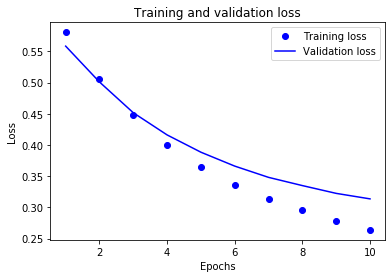

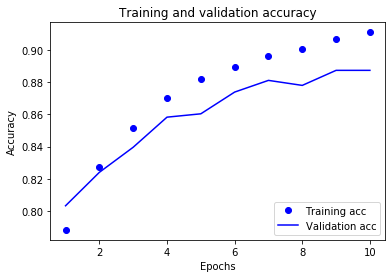

In [23]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In these plots, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

The training loss decreases with each epoch and the training accuracy increases with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak after about twenty epochs. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.